In [52]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

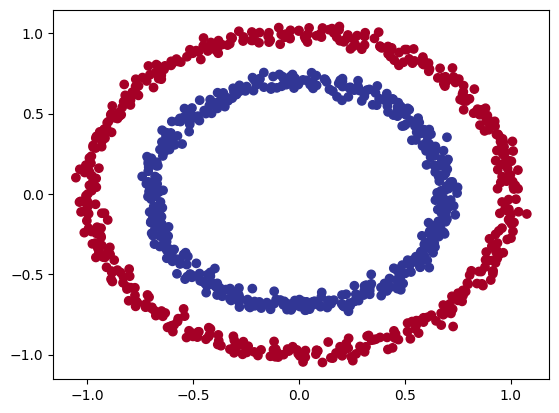

In [90]:
#Creating Data
circle_amount = 1000
#! The X and y is still in numpy form
X, y = make_circles(circle_amount, noise=0.03, random_state=128, factor=0.7)#Factor is how far they are
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)

#Making them to tensors
X_train = torch.from_numpy(X_train).type(torch.float32).to(device=device).squeeze()
X_test = torch.from_numpy(X_test).type(torch.float32).to(device=device).squeeze()
y_train = torch.from_numpy(y_train).type(torch.float32).to(device=device).squeeze()
y_test = torch.from_numpy(y_test).type(torch.float32).to(device=device).squeeze()

In [287]:
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #The layers, only one hidden layer
        self.layer_1 = nn.Linear(in_features=2, out_features=3)
        self.layer_2 = nn.Linear(in_features=3, out_features=2)
        self.layer_3 = nn.Linear(in_features=2, out_features=1)
        self.tanh = nn.Tanh()
    def forward(self, x:torch.Tensor) -> torch.Tensor:
       return self.layer_3(self.tanh(self.layer_2(self.tanh(self.layer_1(x)))))

model_0 = CircleModelV0().to(device=device)
# Replicate CircleModelV0 with nn.Sequential

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=2, bias=True)
  (layer_3): Linear(in_features=2, out_features=1, bias=True)
  (tanh): Tanh()
)

In [288]:
# Make predictions with the model
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_pred_probs = torch.sigmoid(y_logits) #The sigmoid helps it 
y_pred_probs

y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)))
# Check for equality
y_pred_labels.squeeze()[:5], y_test[:5]

(tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([0., 1., 1., 0., 1.], device='cuda:0'))

In [289]:
#loos_fn = nn.BCELoss() #no sigmoid built in 
loss_fn = nn.BCEWithLogitsLoss() #sigmoid built in

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.3)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [290]:
torch.manual_seed(128)

epochs = 220

for epoch in range(epochs):
    ##Training
    model_0.train()
    #Forward
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))#Turning 0.34 to .0

    #Calculate loss
    loss = loss_fn(y_logits, y_train) #Since were using BCELogitsLss we don't need sigmoid
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    #Optmizer
    optimizer.zero_grad()
    
    #Backward
    loss.backward()

    optimizer.step()

    #Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    #What's happining?
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, acc: {acc}, Test acc: {test_acc} ")




Epoch: 0, acc: 49.5, Test acc: 48.0 
Epoch: 10, acc: 73.75, Test acc: 61.0 
Epoch: 20, acc: 76.625, Test acc: 72.5 
Epoch: 30, acc: 77.625, Test acc: 72.5 
Epoch: 40, acc: 79.5, Test acc: 71.0 
Epoch: 50, acc: 79.5, Test acc: 73.0 
Epoch: 60, acc: 79.875, Test acc: 73.0 
Epoch: 70, acc: 80.625, Test acc: 72.5 
Epoch: 80, acc: 79.625, Test acc: 72.5 
Epoch: 90, acc: 80.0, Test acc: 73.0 
Epoch: 100, acc: 79.875, Test acc: 76.5 
Epoch: 110, acc: 80.75, Test acc: 76.5 
Epoch: 120, acc: 80.625, Test acc: 74.5 
Epoch: 130, acc: 80.75, Test acc: 73.0 
Epoch: 140, acc: 84.5, Test acc: 76.5 
Epoch: 150, acc: 77.375, Test acc: 77.0 
Epoch: 160, acc: 89.0, Test acc: 87.5 
Epoch: 170, acc: 90.75, Test acc: 86.5 
Epoch: 180, acc: 92.375, Test acc: 91.0 
Epoch: 190, acc: 99.5, Test acc: 95.0 
Epoch: 200, acc: 99.75, Test acc: 100.0 
Epoch: 210, acc: 100.0, Test acc: 100.0 


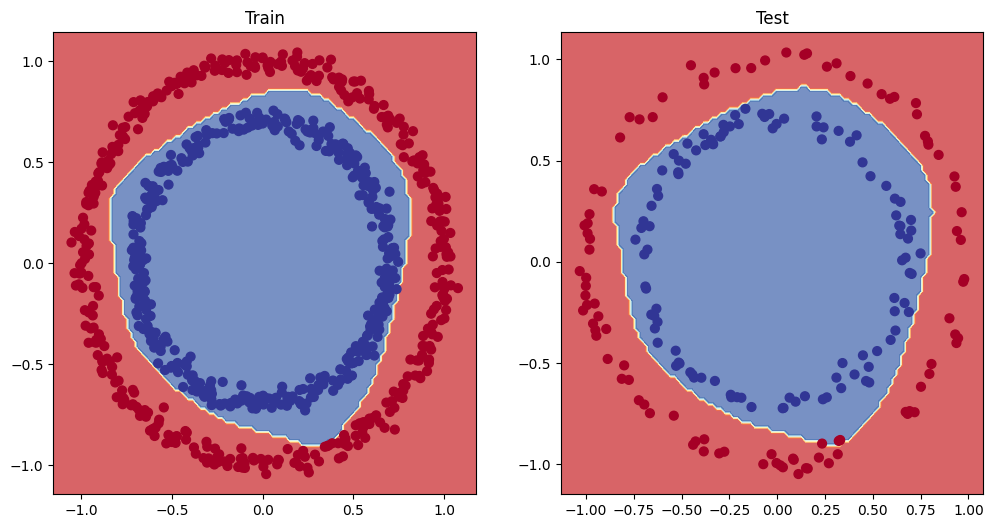

In [291]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) 